# <center><font color=red>--- TP Fusion et multimodalité --- </font></center>

<b>Réalisé par:</b> Nasreddine Menacer<br>


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

### Lecture du Dataset 

In [39]:
donnees = pd.read_csv('wdbc.data', header=None)

In [40]:
donnees.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Convertir les labels de type string en type entier 

In [41]:
# conversion des labels de type string en type entier car les forets aléatoire accepte que les valeurs numérique 
for i in range(len(donnees.iloc[:,1])):
    if donnees.iloc[:,1][i]=='M':
       donnees.iloc[:,1][i]=1
    if donnees.iloc[:,1][i]=='B':
       donnees.iloc[:,1][i]=0

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Boosting

laccuracy du modèle avec 50 arbre  37.258347978910365 %


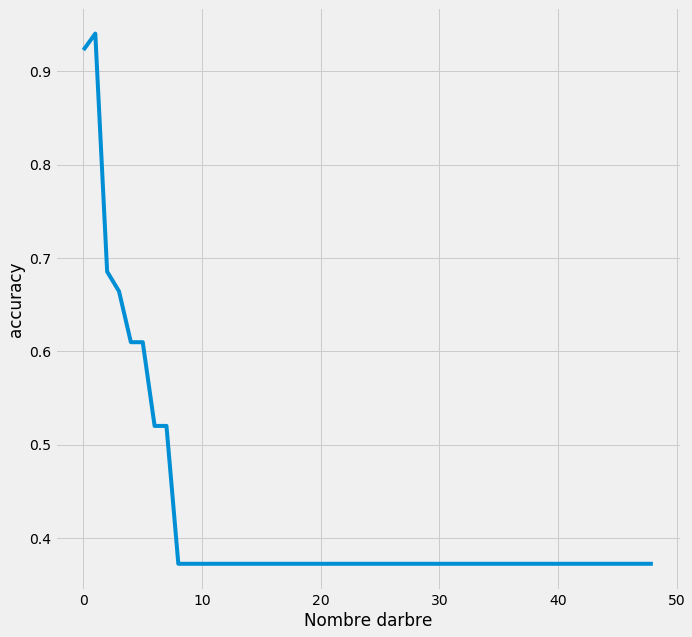

In [71]:
class Boosting:
    def __init__(self,donnees,Mod_Pond,donnees_test):
        self.donnees = donnees
        self.Mod_Pond = Mod_Pond
        self.donnees_test = donnees_test
        self.les_alphas = None
        self.modeles = None
        self.accuracy = []
        self.predictions = None
    
    def Entrainement(self):
        # séparaton des données et des label 
        X = self.donnees.drop(donnees[1],axis=1)
        Y = self.donnees[1].where(self.donnees[1]==1,0).where(self.donnees[1]==1,0)
        Y=list(Y)

        # Initialisation des poids
        Evaluation = pd.DataFrame(Y.copy())
        Evaluation['weights'] = 1/len(self.donnees) 
        
        les_alphas = [] 
        modeles = []
        
        for i in range(self.Mod_Pond):
            # Entrainement 
            Tree_model = DecisionTreeClassifier(max_depth=1) 
            
            # les poids dépendent des résultats de la décision précédente
            model = Tree_model.fit(X,Y,sample_weight=np.array(Evaluation['weights'])) 
        
            # les modele entrainés sont remplis dans la liste modeles 
            modeles.append(model)
            
            # calcule du score de la prediction d'un seul modele
            predictions = model.predict(X)
            result = model.score(X,Y)

            # création du dataframe evaluation et le remplir des valeurs (score, les prédictions et les données mal classés)
            Evaluation['predictions'] = predictions
            Evaluation['evaluation'] = np.where(Evaluation['predictions'] == Evaluation[0],1,0)
            Evaluation['mal_classe'] = np.where(Evaluation['predictions'] != Evaluation[0],1,0)

            # calcule de l'accuracy et du taux de mal classification 
            accuracy = sum(Evaluation['evaluation'])/len(Evaluation['evaluation'])
            mal_classification = sum(Evaluation['mal_classe'])/len(Evaluation['mal_classe'])


            # Caclulate the erreuror
            erreur = np.sum(Evaluation['weights']*Evaluation['mal_classe'])/np.sum(Evaluation['weights'])
 
   
            # calcules des valeurs de alpha
            alpha = np.log((1-erreur)/erreur)
            les_alphas.append(alpha)


            # utilisation des poids d'un arbre de decision pour l'arbre de decision suivant 
            Evaluation['weights'] *= np.exp(alpha*Evaluation['mal_classe'])

        
        self.les_alphas = les_alphas
        self.modeles = modeles
            
    def predict(self):
        
        # création des données de teste, apartir des données initiales, en les ré-organisant
        # puisque les données utilisée pour l'entrainement sont organisées d'une autre façon 
        # et donc tous les arbres de decision n'auront pas vus les données de teste meme si ce sont les memes données 
        # reindex est une fonction qui réorganise les indexe aléatoirement 
        X_test = self.donnees.drop(donnees[1],axis=1).reindex(range(len(self.donnees_test)))
        Y_test = self.donnees[1].reindex(range(len(self.donnees))).where(self.donnees[1]==1,0)
        
        accuracy = []
        predictions = []
        
        for alpha,model in zip(self.les_alphas,self.modeles):
            prediction = alpha*model.predict(X_test) 
            predictions.append(prediction)
            self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0]))
         
        self.predictions = np.sign(np.sum(np.array(predictions),axis=0))

# Affichage de la précision du modèle par rapport au nombre d'arbre utilisées 

nombre_max_arbre = 50

fig = plt.figure(figsize=(10,10))


for i in range(nombre_max_arbre):
    model = Boosting(donnees,i,donnees)
    model.Entrainement()
    model.predict()

plt.plot(range(len(model.accuracy)),model.accuracy)
plt.xlabel('Nombre darbre')
plt.ylabel('accuracy')
print('laccuracy du modèle avec 50 arbre ',(model.accuracy[-1])*100,'%')    
                 
plt.show()        

# Bagging

In [125]:
data= pd.read_csv('wdbc.data',header=None)
# séparation de données et des labels sous forme de np.array
y=np.array(data[1])
data2=data[data.columns[2:]]
X=np.array(data2)

In [131]:
# fonction pour la création de sous-échantillons avec remplacement 
def subsample(dataset, ratio=1.0):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = rd.randrange(len(dataset))
        sample.append(dataset[index])
    return sample

In [135]:
def bagging(data, label, tree):
    score = []
    sp = splitting(data, label)
    for i in range(tree):
        decision_tree = DecisionTreeClassifier(max_depth=1)
        Xx = subsample(sp[0])
        Yy = subsample(sp[2])
        clf = decision_tree.fit(Xx, Yy)
        y_pred = decision_tree.predict(sp[1])
        score.append(clf.score(sp[1], sp[3]))
    return score

In [162]:
n_tree=[1,5,10,15,20,25,30,35,40,45,50]
score=[]
for i in n_tree:
        score.append(bagging(X,y,i))

In [165]:
Acc=[]
for u in range (len(score)):
    Acc.append(score[u][-1])

laccuracy du Bagging avec 50 arbres  64.36170212765957 %


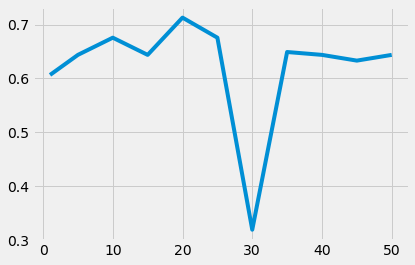

In [169]:
plt.plot(n_tree,Acc)
print('laccuracy du Bagging avec 50 arbres ',(Acc[10])*100,'%') 